## aggregate

> This module aggregates the downloaded data into the respective output dataframes.

In [1]:
#| default_exp aggregate


In [2]:
#| hide
from nbdev.showdoc import *

We prototyped the code in this module using a Jupyter notebook. The notebook is available in `notes/prototypes/learning_aggregations_w_michelle_20250328.ipynb`. The code in this module is a cleaned-up version of the code in that notebook. The notebook contains additional comments and explanations of the code, which may be helpful for understanding the code in this module.

The basic process is as follows:

1. Load the netCDF data in memory
2. Statistically aggregate the hourly data to daily data per exposure using resample()
3. Write out the data to tiff
4. Read the tiff data back in
5. Read in the shapefile that defines the healthsheds
6. Spatially aggregate the exposure data to the healthsheds
7. Quality check the aggregations
8. Write out final aggregations to tiff

In [3]:
#| export

import tempfile
import rasterio
import hydra
import argparse

import pandas as pd
import geopandas as gpd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from dataclasses import dataclass, field
from typing import Optional, Tuple
from pyprojroot import here
from hydra import initialize, compose
from omegaconf import OmegaConf, DictConfig
from tqdm import tqdm
from math import ceil, floor
from rasterstats.io import Raster
from rasterstats.utils import boxify_points, rasterize_geom

try: from era5_sandbox.core import GoogleDriver, _get_callable, describe
except: from core import GoogleDriver, _get_callable, describe

In [4]:
with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name='config.yaml')

We're going to write a function that aggregates the data for a single exposure from a file. This file should be the single month data we got from the previous step in the pipeline.

In [5]:
eg_file = here() / "data/input/2010_1.nc"

In [6]:
#| export 

def resample_netcdf(
        fpath: str, # Path to the netCDF file.
        resample: str = "1D", # Resampling frequency (e.g., '1H', '1D')
        agg_func: callable = np.mean, # Aggregation function (e.g., np.mean, np.sum).
        time_dim: str = "valid_time" # Name of the time dimension in the dataset.
    ) -> xr.Dataset:   
    """
    Resample a netCDF file to a specified frequency and aggregation method.
    
    Args:
        fpath (str): Path to the netCDF file.
        resample (str): Resampling frequency (e.g., '1H', '1D').
        agg_func (callable): Aggregation function (e.g., np.mean, np.sum).
    
    Returns:
        xarray.Dataset: Resampled dataset.
    """

    ds = xr.open_dataset(fpath)

    if callable(agg_func):
        # Use xarray's reduce method with the callable
        return ds.resample({time_dim: resample}).reduce(agg_func)
    else:
        raise TypeError("agg_func must be a callable function like np.mean, np.max, etc.")

In [7]:
resample_netcdf(eg_file)

<xarray.Dataset> Size: 484kB
Dimensions:     (valid_time: 31, latitude: 59, longitude: 33)
Coordinates:
    number      int64 8B 0
  * latitude    (latitude) float64 472B -11.6 -11.85 -12.1 ... -25.85 -26.1
  * longitude   (longitude) float64 264B 42.7 42.95 43.2 ... 50.2 50.45 50.7
  * valid_time  (valid_time) datetime64[ns] 248B 2010-01-01 ... 2010-01-31
Data variables:
    d2m         (valid_time, latitude, longitude) float32 241kB 297.7 ... 293.1
    t2m         (valid_time, latitude, longitude) float32 241kB 300.9 ... 297.9
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-03-27T17:15 GRIB to CDM+CF via cfgrib-0.9.1...

I'm going to use a dataclass to represent the tiff data. This will allow us to easily pass around the data and metadata associated with the tiff file. Why? Because I can, lol (I've never used dataclasses and I'm curious about them). ChatGPT thinks this will make the code cleaner and easier to read.

In [8]:
#| export

@dataclass
class RasterFile:
    path: str
    data: Optional[np.ndarray] = field(default=None, init=False)
    transform: Optional[rasterio.Affine] = field(default=None, init=False)
    crs: Optional[str] = field(default=None, init=False)
    nodata: Optional[float] = field(default=None, init=False)
    bounds: Optional[Tuple[float, float, float, float]] = field(default=None, init=False)

    def load(self):
        """Load raster data and basic metadata."""
        with rasterio.open(self.path) as src:
            self.data = src.read(1)  # first band
            self.transform = src.transform
            self.crs = src.crs
            self.nodata = src.nodata
            self.bounds = src.bounds
        return self

    def shape(self) -> Optional[Tuple[int, int]]:
        """Return the shape of the raster data."""
        return self.data.shape if self.data is not None else None

    def __str__(self):
        return f"RasterFile(path='{self.path}', shape={self.shape()}, crs='{self.crs}')"

Next, a function to write and read the netCDF to tiff:

In [9]:
#| export

def netcdf_to_tiff(
    ds: xr.Dataset, # The aggregated xarray dataset to convert.    
    variable: str, # The variable name to convert.
    crs: str = "EPSG:4326", # Coordinate reference system (default is WGS84).    
    ):

    """
    Convert a netCDF file to a GeoTIFF file.
    
    Args:
        fpath (str): Path to the netCDF file.
        output_path (str): Path to save the output GeoTIFF file.
        variable_name (str): Name of the variable to convert.
        time_index (int): Index of the time dimension to extract.
    """

    with tempfile.TemporaryDirectory() as tmpdirname:

        # Select the variable and time index
        variable = ds[variable]
        ds_ = variable.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude")
        ds_ = ds_.rio.write_crs(crs)
        # Save as GeoTIFF
        variable.rio.to_raster(f"{tmpdirname}/output.tif")
        # Load the raster file
        raster_file = RasterFile(f"{tmpdirname}/output.tif").load()

    return raster_file

Now to test it:

In [10]:
resampled_nc = resample_netcdf(eg_file)

resampled_tiff = netcdf_to_tiff(
    ds=resampled_nc,
    variable="t2m",
    crs="EPSG:4326"
)

In [11]:
resampled_tiff.data.shape, resampled_tiff.transform, resampled_tiff.crs, resampled_tiff.bounds

((59, 33),
 Affine(0.25, 0.0, 42.575,
        0.0, -0.25000000000000006, -11.475),
 None,
 BoundingBox(left=42.575, bottom=-26.225, right=50.825, top=-11.475))

Super cool! The tiff file is created and the data is read back in correctly. Now we can move on to the next step, which is to aggregate the data by healthshed.

## Polygon to Raster Cells

This function was initially shared from a previous NSAPH aggregation pipeline [here](https://github.com/NSAPH-Data-Processing/air_pollution__aqdh/blob/2a8109075fe7a8fbf7c435cc34ffa97b63f5e133/utils/faster_zonal_stats.py#L17). To better understand this, here is a ChatGPT explanation of the code:

> This function, `polygon_to_raster_cells`, is doing a crucial first step in spatial alignment: it determines which raster cells are “touched” by each polygon geometry (e.g., administrative areas, watersheds, etc.).    
Essentially, this function helps figure out which pixels from a raster image fall inside each polygon (like a district, region, or shape). It does this by looking at each polygon one by one, zooming in on just the part of the raster that overlaps with that shape, and marking the pixels that are inside. This is kind of like placing a cookie cutter (the polygon) on a pixelated map (the raster) and seeing which pixels get cut.  
The result is a list where each item tells you the pixel locations that match a specific polygon. You can then use those pixel locations to pull out data from the raster, like temperatures or rainfall, and calculate statistics (like the average) for each shape. This is a key step when you want to summarize raster data within specific regions, like figuring out the average temperature in each county or how much vegetation is in each park.

In [12]:
#| export 

def polygon_to_raster_cells(
    vectors,
    raster,
    band=1,
    nodata=None,
    affine=None,
    all_touched=False,
    verbose=False,
    **kwargs,
):
    """Returns an index map for each vector geometry to indices in the raster source.

    Parameters
    ----------
    vectors: list of geometries

    raster: ndarray

    nodata: float

    affine: Affine instance

    all_touched: bool, optional
        Whether to include every raster cell touched by a geometry, or only
        those having a center point within the polygon.
        defaults to `False`

    Returns
    -------
    dict
        A dictionary mapping vector the ids of geometries to locations (indices) in the raster source.
    """

    cell_map = []

    with Raster(raster, affine, nodata, band) as rast:
        # used later to crop raster and find start row and col
        min_lon, dlon = affine.c, affine.a
        max_lat, dlat = affine.f, -affine.e
        H, W = rast.shape

        for geom in tqdm(vectors, disable=(not verbose)):
            if "Point" in geom.geom_type:
                geom = boxify_points(geom, rast)

            # find geometry bounds to crop raster
            # the raster and geometry must be in the same lon/lat coordinate system
            start_row = max(0, min(H - 1, floor((max_lat - geom.bounds[3]) / dlat)))
            start_col = min(W - 1, max(0, floor((geom.bounds[0] - min_lon) / dlon)))
            end_col = max(0, min(W - 1, ceil((geom.bounds[2] - min_lon) / dlon)))
            end_row = min(H - 1, max(0, ceil((max_lat - geom.bounds[1]) / dlat)))
            geom_bounds = (
                min_lon + dlon * start_col,  # left
                max_lat - dlat * end_row - 1e-12,  # bottom
                min_lon + dlon * end_col + 1e-12,  # right
                max_lat - dlat * start_row,  # top
            )

            # crop raster to area of interest and rasterize
            fsrc = rast.read(bounds=geom_bounds)
            rv_array = rasterize_geom(geom, like=fsrc, all_touched=all_touched)
            indices = np.nonzero(rv_array)

            if len(indices[0]) > 0:
                indices = (indices[0] + start_row, indices[1] + start_col)
                assert 0 <= indices[0].min() < rast.shape[0]
                assert 0 <= indices[1].min() < rast.shape[1]
            else:
                pass  # stop here for debug

            cell_map.append(indices)

        return cell_map

To use this, we must define the polygon and raster data. The polygon data is the healthshed shapefile, and the raster data is the tiff file we created earlier. We can use the `GoogleDriver` class we defined in `core` to read in the shapefile.

In [13]:
with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name='config.yaml')

driver = GoogleDriver(json_key_path=here() / cfg.GOOGLE_DRIVE_AUTH_JSON.path)
drive = driver.get_drive()
healthsheds = driver.read_healthsheds("healthsheds2022.zip")

In [14]:
res_poly2cell=polygon_to_raster_cells(
    vectors = healthsheds.geometry.values, # the geometries of the shapefile of the regions
    raster=resampled_tiff.data, # the raster data above
    band=1, # the value of the day that we're using
    nodata=resampled_tiff.nodata, # any intersections with no data, may have to be np.nan
    affine=resampled_tiff.transform, # some math thing need to revise
    all_touched=True, 
    verbose=True
)

  0%|          | 0/2766 [00:00<?, ?it/s]/n/home03/ttapera/.conda/envs/era5_sandbox/lib/python3.11/site-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(
100%|██████████| 2766/2766 [00:01<00:00, 1576.17it/s]


The data below maps which grid entries fall into each of the regions in the shapefile (e.g. which pixel is in which state)

In [15]:
res_poly2cell[:5]

[(array([37, 38, 38]), array([22, 21, 22])),
 (array([30]), array([21])),
 (array([38, 38]), array([22, 23])),
 (array([40, 41]), array([18, 18])),
 (array([30]), array([20]))]

Last but not least, we aggregate these data to the healthshed level. We can use the `rasterstats` package to do this.

In [16]:
#| export

def aggregate_to_healthsheds(
    res_poly2cell: list, # the result of polygon_to_raster_cells    
    raster: RasterFile, # the raster data
    shapes: gpd.GeoDataFrame, # the shapes of the health sheds
    names_column: str = "fs_uid", # the unique identifier column name of the health sheds
    aggregation_func: callable = np.nanmean, # the aggregation function
    aggregation_name: str = "mean" # the name of the aggregation function
    ) -> gpd.GeoDataFrame:
    """
    Aggregate the raster data to the health sheds.
    """

    stats = []

    for indices in res_poly2cell:
        if len(indices[0]) == 0:
            # no cells found for this polygon
            stats.append(np.nan)
        else:
            cells = raster.data[indices]
            if sum(~np.isnan(cells)) == 0:
                # no valid cells found for this polygon
                stats.append(np.nan)
                continue
            else:
                # compute MEAN of valid cells
                # but this stat can be ANYTHING
                stats.append(aggregation_func(cells))

    # clean up the result into a dataframe
    stats = pd.Series(stats)
    shapes[aggregation_name] = stats
    df = pd.DataFrame(
            {"healthshed": shapes[names_column], aggregation_name: stats}
        )
    gdf = gpd.GeoDataFrame(df, geometry=shapes.geometry.values, crs=shapes.crs)
    return gdf


And now we apply it:

In [17]:
result = aggregate_to_healthsheds(
    res_poly2cell=res_poly2cell,
    raster=resampled_tiff,
    shapes=healthsheds,
    names_column="fs_uid",
    aggregation_func=np.nanmean,
    aggregation_name="mean_temperature"
)
result.head()

,healthshed,mean_temperature,geometry
0,A0YU5ksfXZS,299.405884,"POLYGON ((48.21537 -20.95662, 48.21593 -20.956..."
1,A1SY9AiVPYF,293.992493,"POLYGON ((47.85923 -19.09954, 47.8601 -19.0998..."
2,A38WhL0NPsX,299.790161,"POLYGON ((48.35588 -21.05353, 48.35801 -21.057..."
3,A6fVNQgqqJg,295.190308,"POLYGON ((47.18552 -21.70624, 47.19275 -21.711..."
4,A77QRkmKUul,293.442169,"POLYGON ((47.73249 -19.15372, 47.73267 -19.153..."


And plot for QA:

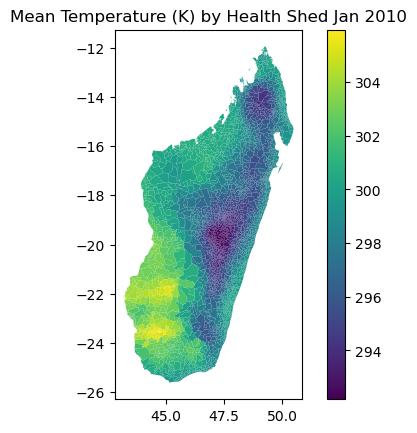

In [18]:
result.plot(column="mean_temperature", legend=True)
plt.title("Mean Temperature (K) by Health Shed Jan 2010")
plt.show()

That looks great! The data is aggregated to the healthshed level, and we can see the differences in exposure across the healthsheds. We can also see that the data is not uniform across the healthsheds, which is what we expect.

## Tests and Main

Now we can wrap this up in a main function that will simply take in the input file and generate this output. We can also add some tests to make sure the data is aggregated correctly; tests will run automatically in this notebook.

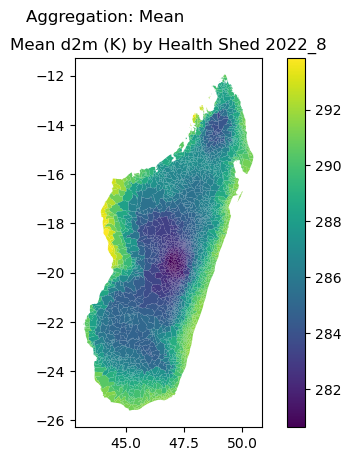

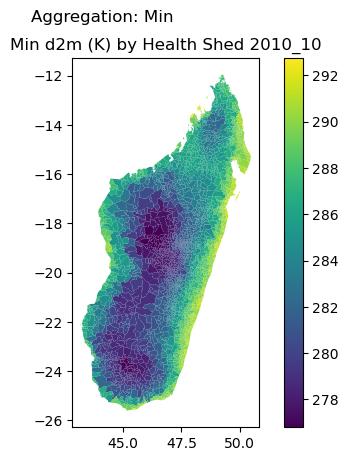

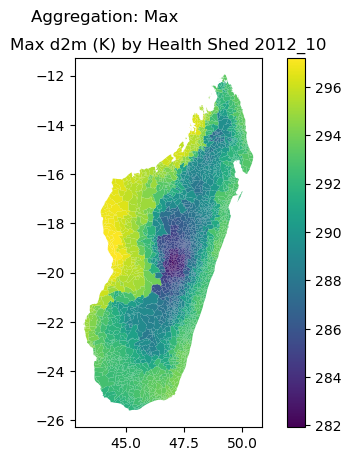

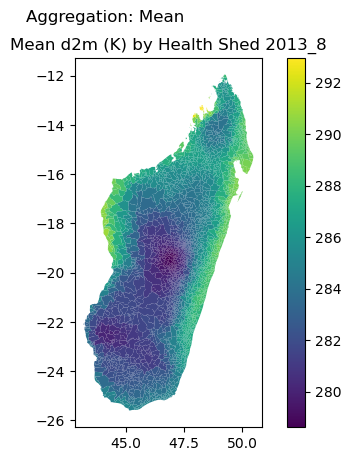

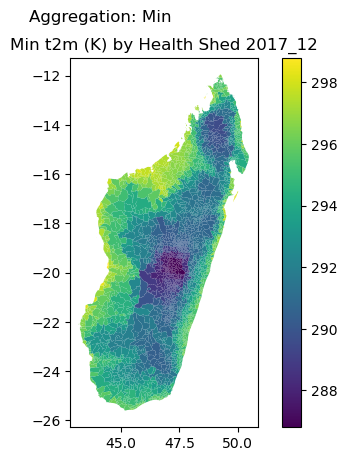

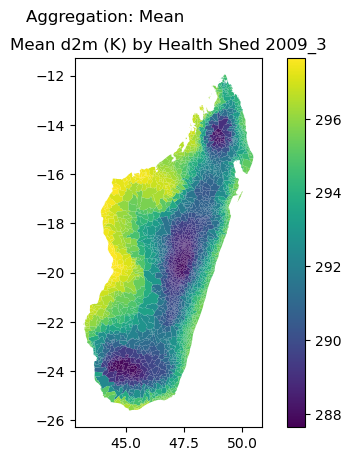

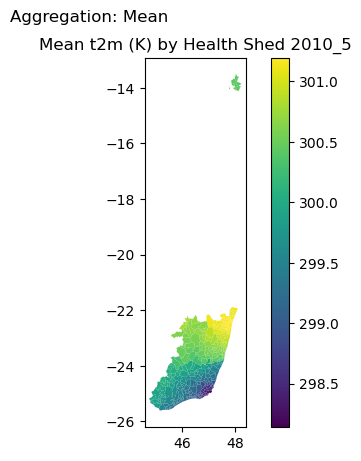

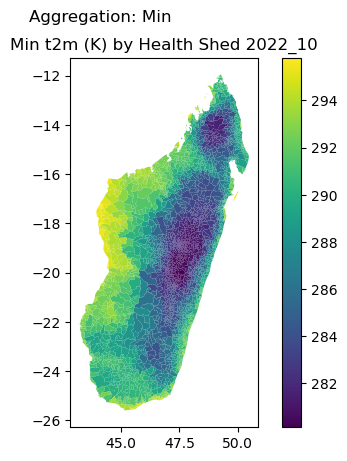

3.6 s ± 286 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%%timeit

import random

variables = ["t2m", "d2m"]
years = ["20{:02d}".format(m) for m in range(9, 24)]
months = [str(m) for m in range(1, 13)]
aggregations = [
    ("Mean", np.nanmean),
    ("Max", np.nanmax),
    ("Min", np.nanmin)
]

exposure_variable = random.choice(variables)
year = random.choice(years)
month = random.choice(months)
aggregation_str, agg_func = random.choice(aggregations)
input_file = here() / "data/input/{}_{}.nc".format(year, month)

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name='config.yaml')

driver = GoogleDriver(json_key_path=here() / cfg.GOOGLE_DRIVE_AUTH_JSON.path)
drive = driver.get_drive()
healthsheds = driver.read_healthsheds(cfg.GOOGLE_DRIVE_AUTH_JSON.healthsheds_id)


resampled_nc_file = resample_netcdf(input_file, agg_func=agg_func)

resampled_tiff = netcdf_to_tiff(
    ds=resampled_nc_file,
    variable=exposure_variable,
    crs="EPSG:4326"
)

result = aggregate_to_healthsheds(
    res_poly2cell=res_poly2cell,
    raster=resampled_tiff,
    shapes=healthsheds,
    names_column="fs_uid",
    aggregation_func=agg_func,
    aggregation_name=exposure_variable
)

result.plot(column=exposure_variable, legend=True)
plt.title("{} {} (K) by Health Shed {}".format(aggregation_str, exposure_variable, input_file.stem))
plt.suptitle("Aggregation: {}".format(aggregation_str))
plt.show()

3.2 seconds per aggregation is pretty cool!

For QA, we should come up with the following:

- [ ] A way to list NAs in the data
- [ ] A way to visualize the data temporally
- [ ] A function to convert K to celsius

In [20]:

result.to_parquet(here() / "data/testing/test_aggregation.parquet")

In [ ]:
#| export

def aggregate_data(
        cfg: DictConfig,  # hydra configuration file
        input_file: str, # path to the input file
        output_file: str, # path to the output file
        exposure_variable: str # the variable to aggregate
    )->None:
    '''
    Run the agggregation step of the pipeline.

    Note, this function is the second step in the snakemake 
    pipeline. This means that in order to define the input
    file, we use the snakemake.input and snakemake.output variables
    injected into the runtime by snakemake.
    '''

    if cfg.development_mode:
        describe(cfg)
        return None

    #get geography
    geography = cfg['query'].geography[0]
    
    # get the healthshed shapefile
    driver = GoogleDriver(json_key_path=here() / cfg.GOOGLE_DRIVE_AUTH_JSON.path)
    drive = driver.get_drive()
    healthsheds = driver.read_healthsheds(cfg.geographies[geography].healthsheds)

    # get the aggregation configuration
    # exposure_variable = cfg.aggregation.variable
    agg_func = _get_callable(cfg.aggregation.daily.function)
    
    resampled_nc_file = resample_netcdf(input_file, agg_func=agg_func)

    resampled_tiff = netcdf_to_tiff(
        ds=resampled_nc_file,
        variable=exposure_variable,
        crs="EPSG:4326"
    )

    # run the polygon to raster cell function
    result_poly2cell=polygon_to_raster_cells(
        vectors = healthsheds.geometry.values, # the geometries of the shapefile of the regions
        raster=resampled_tiff.data, # the raster data above
        band=1, # the value of the day that we're using
        nodata=resampled_tiff.nodata, # any intersections with no data, may have to be np.nan
        affine=resampled_tiff.transform, # some math thing need to revise
        all_touched=True, 
        verbose=True
    )

    result = aggregate_to_healthsheds(
        res_poly2cell=result_poly2cell,
        raster=resampled_tiff,
        shapes=healthsheds,
        names_column=cfg.geographies[geography].unique_id,
        aggregation_func=agg_func,
        aggregation_name=exposure_variable
    )

    # Save the result to a file
    result.to_parquet(output_file)

In [24]:
with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name='config.yaml')

cfg.development_mode = False
cfg.query['year'] = 2023
cfg.query['month'] = 10
cfg.query['day'] = 1
cfg.query['time'] = "00:00"
cfg.query['geography'] = "nepal"
aggregate_data(cfg, here() / "data/input/nepal_2023_10.nc", here() / "data/testing/test_nepal_aggregation.parquet", "t2m")

100%|██████████| 777/777 [00:00<00:00, 1105.56it/s]


In [29]:
parquet_file = gpd.read_parquet(here() / "data/testing/test_nepal_aggregation.parquet")

<Axes: >

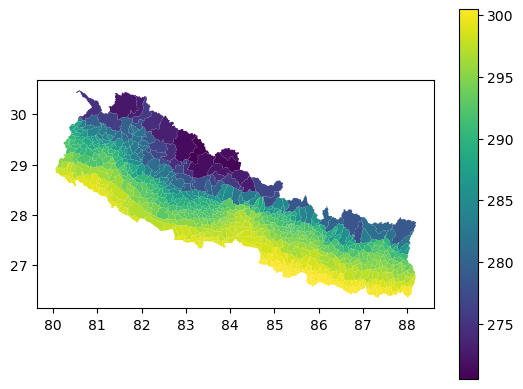

In [31]:
parquet_file.plot(column="t2m", legend=True)

In [ ]:
#| export
@hydra.main(version_base=None, config_path="../../conf", config_name="config")
def main(cfg: DictConfig) -> None:
    # Parse command-line arguments
    input_file = str(snakemake.input[0])  # First input file
    output_file = str(snakemake.output[0])
    aggregation_variable = str(snakemake.params.variable)

    aggregate_data(cfg, input_file=input_file, output_file=output_file, exposure_variable=aggregation_variable)

In [ ]:
#| export
#| eval: false
try: from nbdev.imports import IN_NOTEBOOK
except: IN_NOTEBOOK=False

if __name__ == "__main__" and not IN_NOTEBOOK:
    main()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()